In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *

In [5]:
csv_file = data_meta / "all_info.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

In [6]:
df.Location = df.Location.astype(str)

In [7]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
    
import utils as utils

# Read masks image and corresponding intensity measurement

In [8]:
# Read mask image
masks = utils.get_masks(data_mask)

# Create image based on intensity level of expression 

In [9]:
df_intensity = pd.read_csv(data_meta / 'measurements_intensity.csv')
df_morph = pd.read_csv(data_meta / 'measurements_morphology.csv')
markers = df_intensity.Marker.unique()

In [10]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Location
    i = row.Id
    total_nuclei_intensity = row.Nuclei_mean_intensity * \
        df_morph[(df_morph.Location == cond) & (
            df_morph.Id == i)]['Nuclei_area'].item()
    total_cyto_intensity = row.Cyto_mean_intensity * \
        df_morph[(df_morph.Location == cond) & (
            df_morph.Id == i)]['Cyto_area'].item()
    df_intensity.loc[row.Index,
                     'Nuclei_total_intensity'] = total_nuclei_intensity
    df_intensity.loc[row.Index, 'Cyto_total_intensity'] = total_cyto_intensity

In [101]:
df_intensity

,Cell_mean_intensity,Nuclei_mean_intensity,Cyto_mean_intensity,Marker,Location,Id,Nuclei_total_intensity,Cyto_total_intensity
0,689.296122,1382.594822,403.867185,Cyclin E,1,3,1975728.0,1401823.0
1,975.776122,1391.053184,804.807836,EMMPRIN,1,3,1987815.0,2793488.0
2,212.311224,252.052484,195.949870,Wnt1,1,3,360183.0,680142.0
3,1126.670816,2207.494752,681.698934,Non-phospho-B-catenin,1,3,3154510.0,2366177.0
4,550.292857,685.699090,494.546528,APC,1,3,979864.0,1716571.0
...,...,...,...,...,...,...,...,...
2140,123.265828,183.971641,87.647879,phospho-B-catenin,3,61,518984.0,421411.0
2141,85.746494,86.315491,85.412646,RNF 43,3,61,243496.0,410664.0
2142,169.124918,379.952145,45.426165,AKT,3,61,1071845.0,218409.0
2143,92.849390,128.889401,71.703619,p-mTOR,3,61,363597.0,344751.0


In [102]:
df_morph

,Cell_area,Nuclei_area,Cyto_area,Marker,Location,Id
0,4900,1429,3471,Cyclin E,1,3
1,20881,2098,18783,Cyclin E,1,4
2,9486,1610,7876,Cyclin E,1,5
3,15647,4176,11471,Cyclin E,1,7
4,34947,4412,30535,Cyclin E,1,8
...,...,...,...,...,...,...
138,45214,2552,42662,Cyclin E,3,53
139,18343,4633,13710,Cyclin E,3,56
140,14222,4946,9276,Cyclin E,3,57
141,7797,3043,4754,Cyclin E,3,58


We have {{len(markers)}} markers (no including DAPI and cell segmentation markers) 

# Vizualisation

In [72]:
def get_data_per_condition(df, scaler, condition=None):
    # Read information 
    df_list = []
    df_cell_intensity = df.iloc[:,3:-1]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(['Location'], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:,-2:]
        df_subset['Marker'] = df.Marker
        df_subset['Id'] = df.Location.astype(str) + '_' + df.Id.astype(str)
    df_subset.rename(columns={'Nuclei_total_intensity':'Intensity'}, inplace=True)
    df_subset['Location'] = 'Nuclei'
    df_list.append(df_subset)

    df_cell_intensity = df.iloc[:,[3,4,5,7]]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(['Location'], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:,-2:]
        df_subset['Marker'] = df.Marker
        df_subset['Id'] = df.Location.astype(str) + '_' + df.Id.astype(str)
    df_subset.rename(columns={'Cyto_total_intensity':'Intensity'}, inplace=True)
    df_subset['Location'] = 'Cyto'
    df_list.append(df_subset)

    df_subset = pd.concat(df_list)

    # Pivot the dataframe
    df_per_cell =  df_subset.set_index(['Id','Marker','Location']).unstack().unstack().droplevel(0, axis=1)

    # Scale the data
    x_scaled = scaler.fit_transform(df_per_cell)
    df_per_cell_scaled = pd.DataFrame(x_scaled, index = df_per_cell.index, columns=df_per_cell.columns)
    
    return df_per_cell_scaled

## Per FOV

In [99]:
condition = 3 # Select the condition

scaler = MinMaxScaler()
my_cmap = 'viridis'
scale_name = 'Relative Intensity' 

# scaler = StandardScaler()
# my_cmap = 'bwr'
# scale_name = 'Z-score'

df_per_cell_scaled = get_data_per_condition(df_intensity, scaler, condition=condition)
df_per_cell_scaled.head()

C:\Users\thu71\.conda\envs\work\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\thu71\.conda\envs\work\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Location      Cyto                                                    \
Marker         AKT       APC     AXIN1 Cyclin D1  Cyclin E      DKK1   
Id                                                                     
3         0.039849  0.101216  0.027511  0.049560  0.042348  0.060923   
4         0.005772  0.055827  0.003322  0.035069  0.005802  0.073705   
5         0.103503  0.245885  0.050718  0.108205  0.111141  0.092611   
6         0.077931  0.127363  0.049888  0.082350  0.081872  0.060382   
8         0.465899  0.821579  0.466009  0.594721  0.532970  0.804069   

Location                                                      ...    Nuclei  \
Marker        DKK2   EMMPRIN Non-phospho-B-catenin    RNF 43  ...      DKK1   
Id                                                            ...             
3         0.024522  0.074640              0.089176  0.047562  ...  0.234768   
4         0.000000  0.033378              0.045581  0.051398  ...  0.360232   
5         0.093431  0.112922              0.198220  0.075397  ...  0.180216   
6         0.074618  0.115738              0.110617  0.036398  ...  0.234237   
8         0.402016  0.854880              0.467721  0.813018  ...  1.000000   

Location                                                                \
Marker        DKK2   EMMPRIN Non-phospho-B-catenin    RNF 43      Wnt1   
Id                                                                       
3         0.264522  0.173734              0.331832  0.229119  0.167862   
4         0.267873  0.176851              0.363953  0.327940  0.390658   
5         0.283063  0.201447              0.332588  0.172025  0.210644   
6         0.382396  0.312406              0.414443  0.195590  0.251507   
8         0.992276  1.000000              1.000000  1.000000  0.901269   

Location                                                  
Marker        mTOR     p-AKT    p-mTOR phospho-B-catenin  
Id                                                        
3         0.196730  0.292493  0.166090          0.264650  
4         0.270380  0.189611  0.161744          0.191881  
5         0.130858  0.317625  0.180380          0.284997  
6         0.158103  0.373786  0.208955          0.336994  
8         1.000000  1.000000  1.000000          1.000000  

[5 rows x 30 columns]

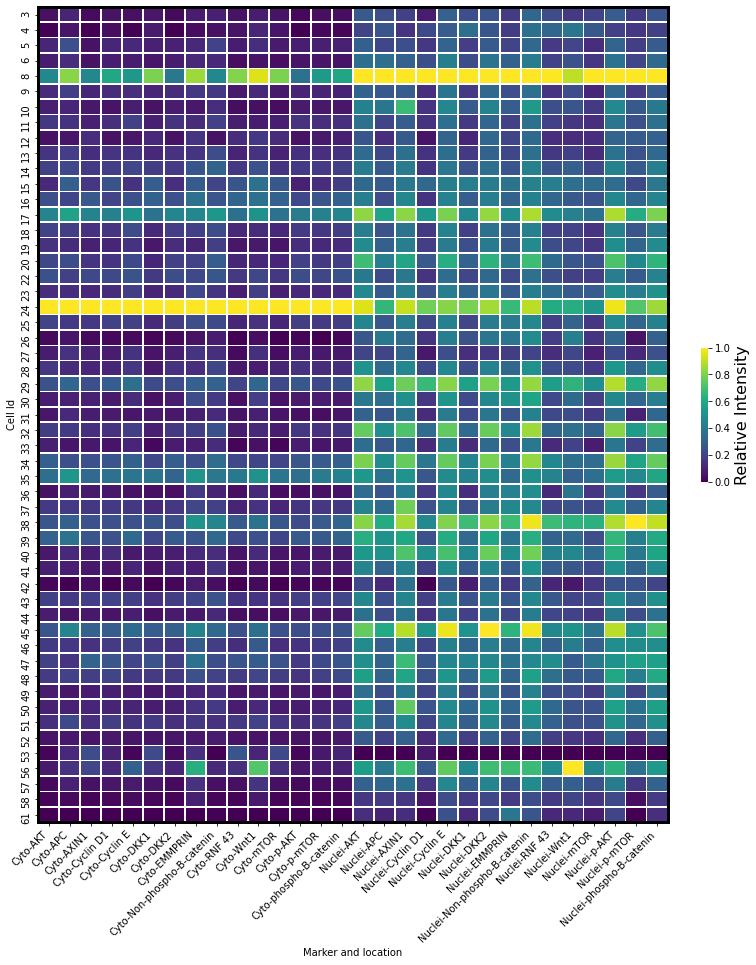

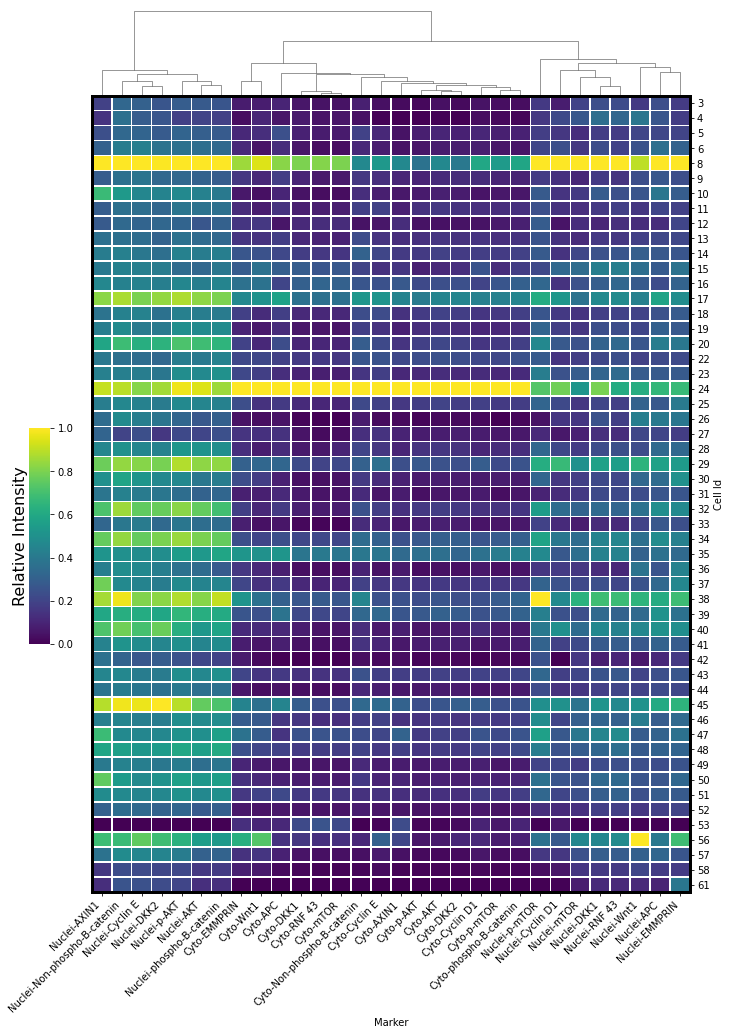

In [100]:
# Heatmap combined
fig, ax = plt.subplots(figsize=(12, 15))
ax = sns.heatmap(df_per_cell_scaled,
                 cbar_kws={'fraction': 0.01},
                 cmap=my_cmap,
                 linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
ax.set_xlabel('Marker and location')
ax.set_ylabel('Cell Id')

# Change colorbar label position
cbar = ax.collections[0].colorbar
cbar.set_label(scale_name, fontsize= 16)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Clustermap 
ax = sns.clustermap(df_per_cell_scaled,
                    cbar_kws={'fraction': 0.01},
                    cmap=my_cmap,
                    linewidth=0.5,
                    row_cluster=False,
                    dendrogram_ratio=(.1, .1),
                    cbar_pos=(.02, .4, .03, .2),
                    figsize=(10, 15))
ax.ax_heatmap.set_xticklabels(
ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.ax_heatmap.set_xlabel('Marker')
ax.ax_heatmap.set_ylabel('Cell Id')

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize= 16, labelpad=-60)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

## All FOV

In [95]:
df_per_cell_scaled = get_data_per_condition(df_intensity, scaler)
df_per_cell_scaled.head()

Location      Cyto                                                    \
Marker         AKT       APC     AXIN1 Cyclin D1  Cyclin E      DKK1   
Id                                                                     
1_10      0.224508  0.233932  0.165809  0.180028  0.319112  0.190476   
1_11      0.036574  0.204285  0.089751  0.076392  0.092108  0.098926   
1_12      0.141656  0.287670  0.132998  0.155750  0.211715  0.130876   
1_13      0.114108  0.189408  0.091717  0.083565  0.126364  0.078458   
1_14      0.103425  0.109997  0.068278  0.074229  0.133550  0.056903   

Location                                                      ...    Nuclei  \
Marker        DKK2   EMMPRIN Non-phospho-B-catenin    RNF 43  ...      DKK1   
Id                                                            ...             
1_10      0.317007  0.295772              0.352737  0.150604  ...  0.342013   
1_11      0.091637  0.121676              0.094986  0.084263  ...  0.478840   
1_12      0.230432  0.239994              0.272733  0.102718  ...  0.507161   
1_13      0.153089  0.124365              0.158796  0.049532  ...  0.379746   
1_14      0.151834  0.113845              0.171986  0.038889  ...  0.144446   

Location                                                                \
Marker        DKK2   EMMPRIN Non-phospho-B-catenin    RNF 43      Wnt1   
Id                                                                       
1_10      0.287954  0.733961              0.314786  0.250596  0.750949   
1_11      0.331247  0.336956              0.363053  0.428974  0.323430   
1_12      0.373160  0.521372              0.419663  0.437197  0.513700   
1_13      0.296673  0.414304              0.324843  0.316689  0.478354   
1_14      0.141107  0.195846              0.150870  0.112568  0.283530   

Location                                                  
Marker        mTOR     p-AKT    p-mTOR phospho-B-catenin  
Id                                                        
1_10      0.228344  0.313674  0.201655          0.370475  
1_11      0.370530  0.330226  0.201845          0.391833  
1_12      0.353110  0.457726  0.274050          0.539169  
1_13      0.281010  0.374579  0.379873          0.418603  
1_14      0.082947  0.177897  0.108152          0.216990  

[5 rows x 30 columns]

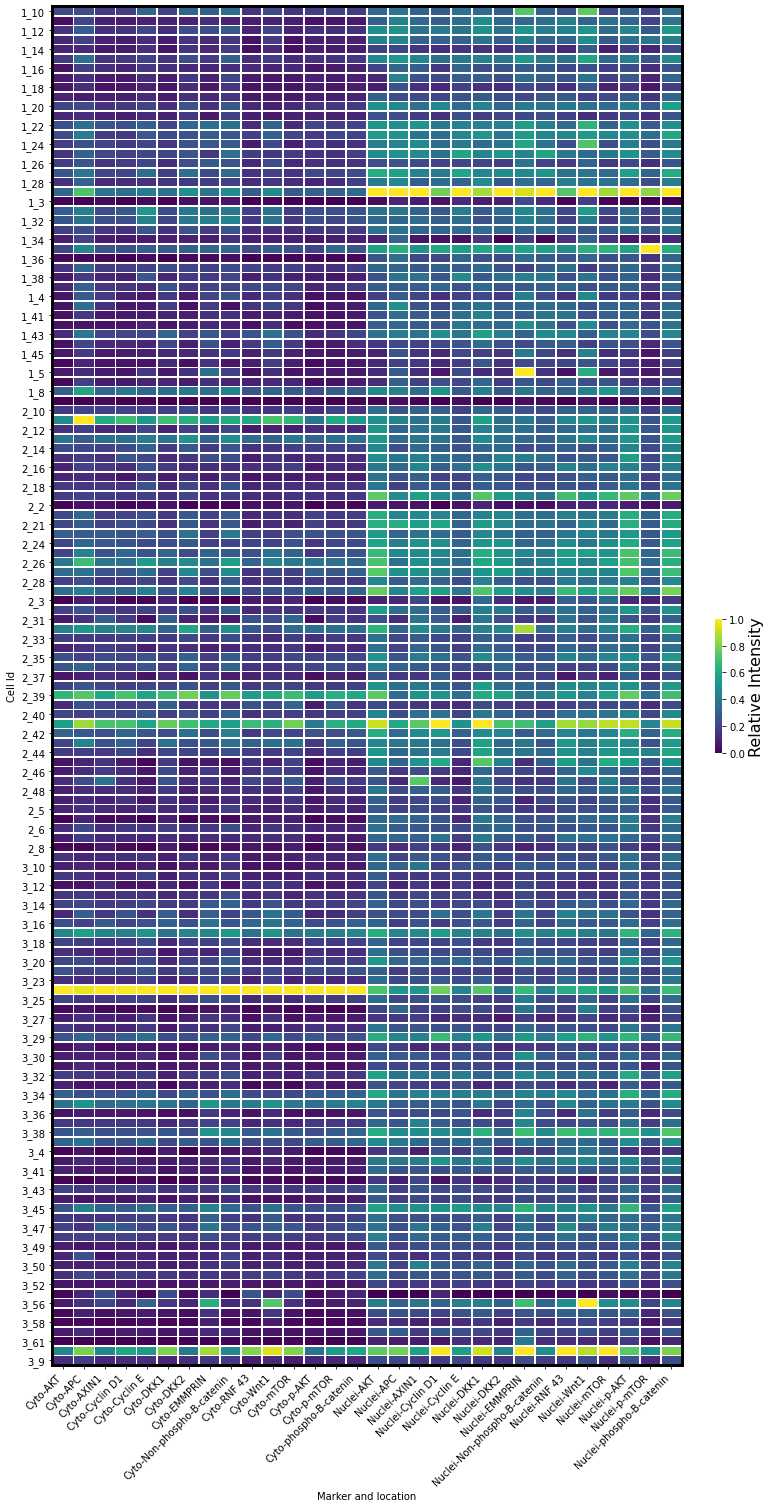

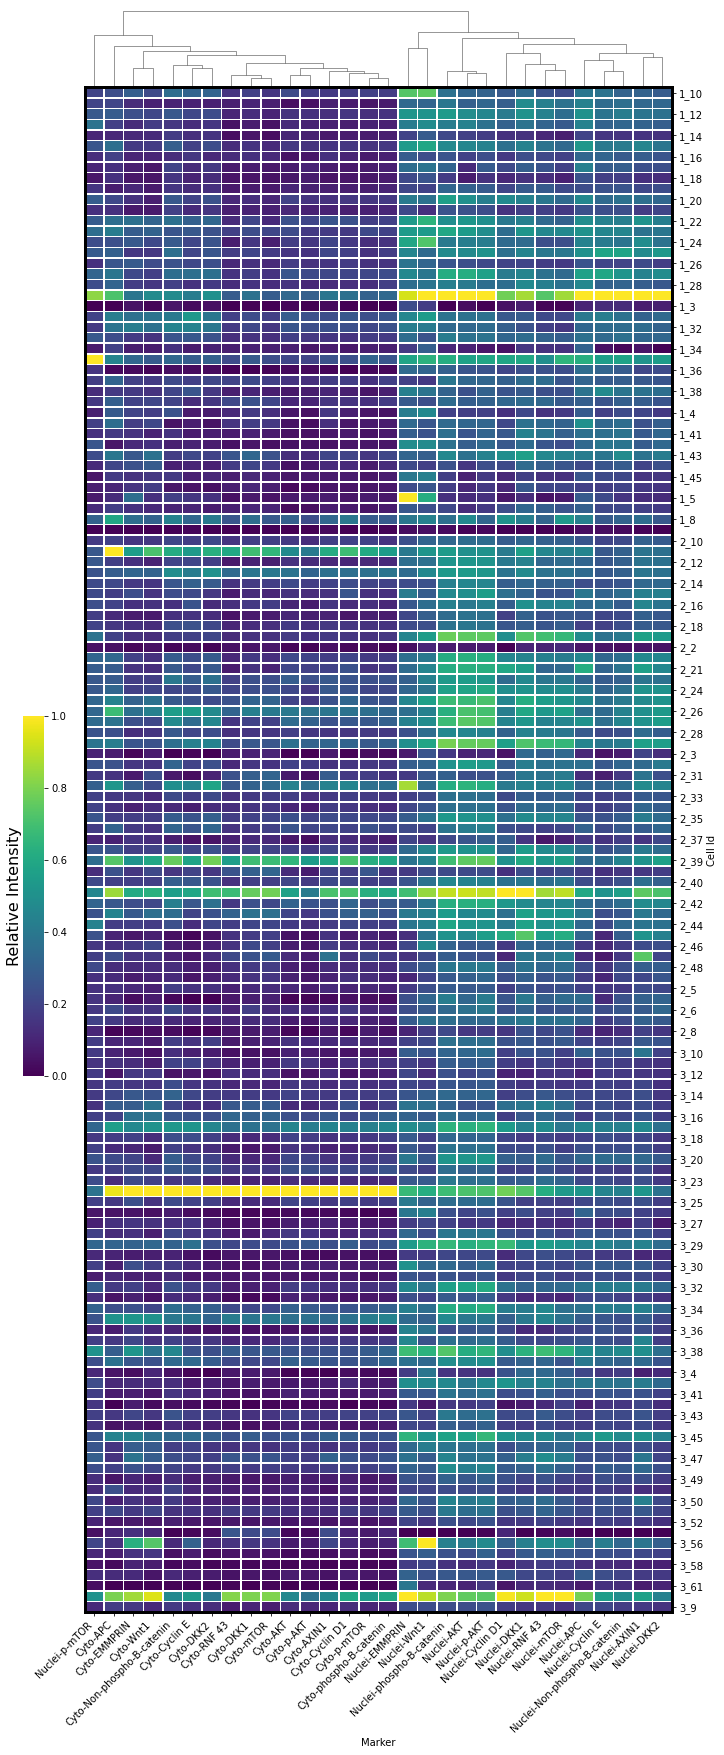

In [96]:
# Heatmap combined
fig, ax = plt.subplots(figsize=(12, 25))
ax = sns.heatmap(df_per_cell_scaled,
                 cbar_kws={'fraction': 0.01},
                 cmap=my_cmap,
                 linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
ax.set_xlabel('Marker and location')
ax.set_ylabel('Cell Id')

# Change colorbar label position
cbar = ax.collections[0].colorbar
cbar.set_label(scale_name, fontsize= 16)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Clustermap 
ax = sns.clustermap(df_per_cell_scaled,
                    cbar_kws={'fraction': 0.01},
                    cmap=my_cmap,
                    linewidth=0.5,
                    row_cluster=False,
                    dendrogram_ratio=(.1, .05),
                    cbar_pos=(.02, .4, .03, .2),
                    figsize=(10, 25))
ax.ax_heatmap.set_xticklabels(
ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.ax_heatmap.set_xlabel('Marker')
ax.ax_heatmap.set_ylabel('Cell Id')

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize= 16, labelpad=-60)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)